In [9]:
import os
import time
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.preprocessing import LabelBinarizer
import torch
import torchaudio
import torch.nn as nn
import torch.nn.functional as F  
from torchsummary import summary
from torch.utils.data import Dataset, DataLoader
from utils import load, get_audio_path, stereo_to_mono, add_noise, time_stretching
# define device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(torch.cuda.is_available())
from torchaudio.transforms import PitchShift

True


In [10]:
DATA_DIR = './fma/data/fma_small'

tracks = load('fma/data/fma_metadata/tracks.csv')
#features = utils.load('fma/data/fma_metadata/features.csv')
#echonest = utils.load('fma/data/fma_metadata/echonest.csv')

subset = tracks.index[tracks['set', 'subset'] <= 'small']

#features_all = features.join(echonest, how='inner').sort_index(axis=1)

tracks = tracks.loc[subset]
#features_all = features.loc[subset]

train = tracks.index[tracks['set', 'split'] == 'training']
val = tracks.index[tracks['set', 'split'] == 'validation']
test = tracks.index[tracks['set', 'split'] == 'test']

labels_onehot = LabelBinarizer().fit_transform(tracks['track', 'genre_top'])
labels_onehot = pd.DataFrame(labels_onehot, index=tracks.index)

In [14]:
class FMADataset(Dataset):
    def __init__(self, data_dir, track_ids, augment_prob=0.5, precomputed=True, subsampling=True, sampling_rate=22050):
        self.data_dir = data_dir
        self.track_ids = track_ids
        self.sampling_rate = sampling_rate
        self.max_length = 750000
        self.subsampling = subsampling
        self.augment_prob = augment_prob
        self.precomputed = precomputed
        # create the Resample transform
        self.resample = torchaudio.transforms.Resample(44100, sampling_rate)
        
        
    def __getitem__(self, index):
        
        tid = self.track_ids[index]
        
    
        if not self.precomputed:
            # load the MP3 file
            filepath = utils.get_audio_path(self.data_dir, tid)
            try:
                waveform, sample_rate = torchaudio.load(filepath)
            except RuntimeError:
                return self.__getitem__(index + 1)

            waveform = stereo_to_mono(waveform) 

            # resample the waveform to the desired sample rate using the Resample transform
            waveform = self.resample(waveform)
        else:
            
            try:
                # load pre-computed waveform resampled to 22050
                filepath = os.path.join('./fma/data/waveforms/'+"{:06d}".format(tid)+'.pt')
                waveform = torch.load(filepath)
            except:
                return self.__getitem__(index + 1)
            
        if torch.rand(1) < self.augment_prob:
            waveform = add_noise(waveform)
            # Apply the PitchShift transform
            # pitch_change =  2  
            # transform = torchaudio.transforms.PitchShift(sample_rate=self.sampling_rate, n_steps=pitch_change, bins_per_octave=12)
            # waveform = transform(waveform)
        
            
        
        # get label
        label = torch.from_numpy(labels_onehot.loc[tid].values).float()
        
        # subsampling
        if self.subsampling:
            # set the length of the subsamples and the overlap
            subsample_length = self.sampling_rate * 5  # 10 seconds
            overlap = int(subsample_length * 0.25)  # 50% overlap
            subsamples = []
            shift = subsample_length - overlap
            for i in range(0, waveform.size(0) - subsample_length + 1, shift):
                
                subsample = waveform[i:(i + subsample_length)]
     
                subsamples.append(subsample)
                #if len(subsamples) == 4: break
                if len(subsamples) == 7: break
            
            # ignore samples that have less than 30s (it should not be the case but there is a 15s sample in validation dataset we dont know why)
            if len(subsamples) != 7: return self.__getitem__(index + 1)
        
            # return the subsamples
            return subsamples, label
        else:
            # padding
            padding = self.max_length - waveform.shape[0]
            padding_tensor = torch.zeros((padding, waveform.shape[1]))
            waveform = torch.cat((waveform, padding_tensor), dim=0)

        
        return waveform, label

    def __len__(self):
        return int(len(self.track_ids)) # using ONLY 50% of the dataset for faster training

In [15]:
from networks_1D import ResNet1D

In [16]:
BATCH = 32
EPOCHS = 20
augment_prob = 0.5
p_dropout = 0.5


# create a training dataset and dataloader
dataset = FMADataset(DATA_DIR, train, precomputed=True)
dataloader = torch.utils.data.DataLoader(dataset, batch_size=BATCH, shuffle=True)

# create a validation dataset and dataloader
val_dataset = FMADataset(DATA_DIR, val, precomputed=True)
val_dataloader = torch.utils.data.DataLoader(val_dataset, batch_size=BATCH, shuffle=True)


    
for subsamples, label in dataloader:
    print(subsamples[0][0].size())
    break

model = ResNet1D(F=32, p_dropout=p_dropout, num_classes=8)
model.to(device)
    
# define the loss function and the optimizer
loss_fn = nn.CrossEntropyLoss()

# Adam optimizer
lr = 0.0001
optimizer = torch.optim.Adam(model.parameters())
optimizer_name = 'Adam'


summary(model, (1, 110250))
timestamp = time.strftime("feb%d_t%H%M", time.gmtime())
model_name = f"{model.name}_B{BATCH}_E{EPOCHS}_O{optimizer_name}_LR{lr}_pD{p_dropout}_A{augment_prob}_{timestamp}"

torch.Size([110250])
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv1d-1            [-1, 32, 36752]              96
            Conv1d-2            [-1, 32, 36752]           3,072
       BatchNorm1d-3            [-1, 32, 36752]              64
            Conv1d-4            [-1, 32, 36752]           3,072
       BatchNorm1d-5            [-1, 32, 36752]              64
            Conv1d-6            [-1, 32, 36752]           1,024
        Res1DLayer-7            [-1, 32, 36752]               0
         MaxPool1d-8             [-1, 32, 4083]               0
            Conv1d-9             [-1, 32, 4083]           3,072
      BatchNorm1d-10             [-1, 32, 4083]              64
           Conv1d-11             [-1, 32, 4083]           3,072
      BatchNorm1d-12             [-1, 32, 4083]              64
           Conv1d-13             [-1, 32, 4083]           1,024
       Res1DLayer-

[1, 200 / 200 batches - 3.16 min]
Validation Accuracy: 0.3018 | Training Accuracy: 0.2303 | Validation Loss: 12.9458 | Training loss: 13.7809 
[2, 200 / 200 batches - 6.49 min]
Validation Accuracy: 0.2821 | Training Accuracy: 0.2576 | Validation Loss: 12.9925 | Training loss: 13.3535 
[3, 200 / 200 batches - 9.92 min]
Validation Accuracy: 0.3318 | Training Accuracy: 0.2653 | Validation Loss: 12.5049 | Training loss: 13.2615 
[4, 200 / 200 batches - 13.23 min]
Validation Accuracy: 0.3625 | Training Accuracy: 0.2699 | Validation Loss: 12.2329 | Training loss: 13.1324 
[5, 200 / 200 batches - 16.55 min]
Validation Accuracy: 0.4114 | Training Accuracy: 0.2808 | Validation Loss: 12.0579 | Training loss: 13.0398 
[6, 200 / 200 batches - 19.87 min]
Validation Accuracy: 0.4039 | Training Accuracy: 0.2993 | Validation Loss: 12.0465 | Training loss: 12.7995 
[7, 200 / 200 batches - 23.17 min]
Validation Accuracy: 0.3996 | Training Accuracy: 0.3072 | Validation Loss: 11.5936 | Training loss: 12.7

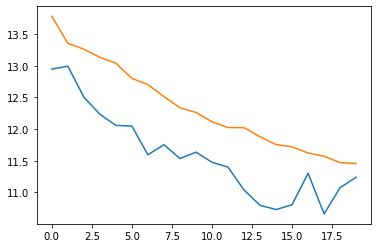

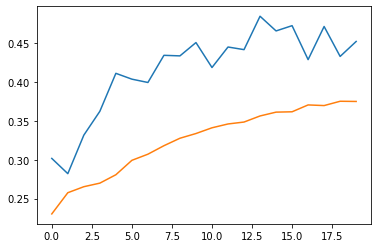

Finished Training


In [17]:

# create the CNN model
#model = ResNet1D(input_size=110250, num_classes=8) # HERE YOU PUT UR NETWORK
#model.to(device)


# Lee 2017
# Define the optimizer
#optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.9, nesterov=True)

# Define the scheduler
#scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', factor=0.2, patience=5)



num_epochs = EPOCHS
running_loss = 0.0
best_val_loss = float('inf') # initialize the best validation loss


t2 = time.time()

# train the model
acc_tr = []
acc_val = []
loss_tr = []
loss_val = []

epoch_len = len(dataset) // BATCH


for epoch in range(num_epochs):
    i = 0
    
    # evaluate the model on the training dataset
    train_correct = 0
    train_total = 0
    
    for subsamples, label in dataloader:
        
        i += 1
        label = label.to(device)
        train_label = torch.argmax(label, dim=1)
        for waveform in subsamples:

            #t2 = time.time()
            # clear the gradients
            optimizer.zero_grad()
            waveform = waveform.to(device)
            # forward pass
            waveform = waveform.squeeze(0)  
            waveform = waveform.unsqueeze(1)
            
            output = model(waveform)
            loss = loss_fn(output, label)

            # backward pass
            loss.backward()
            optimizer.step()  
            
            # Update the learning rate
            # scheduler.step(loss)
            
            _, train_predicted = torch.max(output.data, 1)
            train_total += train_label.size(0)
            train_correct += (train_predicted == train_label).sum().item()

            running_loss += loss.item()
            #print(t2 - time.time())
 
    tr_loss = running_loss / len(dataloader)
    loss_tr.append(tr_loss)
    tr_acc = train_correct / train_total 
    acc_tr.append(tr_acc)
    t1 = (time.time() - t2) / 60 
    #print(epoch + 1, i, epoch_len, t1, loss,  tr_acc)
    running_loss = 0            
    model.eval()
    # evaluate the model on the validation dataset
    val_loss = 0.0
    val_correct = 0
    val_total = 0
    with torch.no_grad():
        for val_subsamples, val_label in val_dataloader:
            val_label = val_label.to(device)
            val_label = torch.argmax(val_label, dim=1)
            for val_waveform in val_subsamples:
                val_waveform = val_waveform.squeeze(0)
                val_waveform = val_waveform.unsqueeze(1)
                val_waveform = val_waveform.to(device)
                val_output = model(val_waveform)
                val_loss += loss_fn(val_output, val_label).item()
                _, val_predicted = torch.max(val_output.data, 1)
                val_total += val_label.size(0)
                val_correct += (val_predicted == val_label).sum().item()


    loss = val_loss / len(val_dataloader)
    loss_val.append(loss)
    val_acc = val_correct / val_total
    acc_val.append(val_acc)
    # Save the model if the validation loss is the best seen so far
    if loss < best_val_loss:
        best_val_loss = loss
        best_val_acc = val_acc
        best_tr_acc = tr_acc
        best_state_dict = model.state_dict()
    print(f'[{epoch+1:d}, {i:d} / {epoch_len:d} batches - {t1:.2f} min]')
    print(f'Validation Accuracy: {val_acc:.4f} | Training Accuracy: {tr_acc:.4f}' + ' | Validation Loss: {:.4f} | Training loss: {:.4f} '.format(loss, tr_loss))  
    model.train()
                
plt.plot(loss_val, label='Validation loss')
plt.plot(loss_tr, label='Training loss')
plt.show()

plt.plot(acc_val, label='Validation accuracy')
plt.plot(acc_tr, label='Training accuracy')
plt.show()

torch.save(best_state_dict, model_name + f'_VAL{best_val_acc:.4f}_TRAIN{best_tr_acc:.4f}.pt')
print('Finished Training')

In [18]:
# if keyboard interrupted:
torch.save(best_state_dict, model_name + f'_VAL{best_val_acc:.4f}_TRAIN{best_tr_acc:.4f}.pt')
#model_name = "ResNet1D_2022-02-02_batchsize_8_epochs_30_opt_Adam_LR_0.0001_acc_0.4614"
#torch.save(model, model_name + '.pt')

In [6]:
#model_name = "ResNet_2022-01-23_batchsize_40_epochs_5_opt_Adam_LR_0.001_acc_"
#model_name = "SoundNet_2022-01-25_batchsize_32_epochs_10_opt_Adam_LR_0.0001_acc_0.3987"
#model_name = "SoundNet_2022-01-25_batchsize_32_epochs_10_20_opt_Adam_LR_0.0001_acc_0.4519"
#model_name = "ResNet_2022-01-23_batchsize_40_epochs_10_opt_Adam_LR_0.001"

a
b


SoundNet 20 epochs BATCH 32 <br>
Validation Loss: 7.2820 | Validation Accuracy: 0.4159 | Training Accuracy: 0.4429 <br>
[9, 230400 subsamples] Training loss: 6.039
Validation Loss: 6.7605 | Validation Accuracy: 0.4103 | Training Accuracy: 0.4553 <br>
[10, 256000 subsamples] Training loss: 6.025
Validation Loss: 7.0612 | Validation Accuracy: 0.3950 | Training Accuracy: 0.4519 <br>

In [36]:
with torch.no_grad():
    torch.cuda.empty_cache()

In [16]:
model = torch.load(model_name+'.pt')
#model.state_dict()

In [ ]:

# create a Mp3Dataset from a directory of MP3 files
dataset = FMADataset(DATA_DIR, train)

# create a DataLoader from the FMADataset
dataloader = torch.utils.data.DataLoader(dataset, batch_size=8, shuffle=True)

    
# create the CNN model
model = ResNet1D(input_size=750000, num_classes=8)

# define the loss function and the optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())

num_epochs = 10
i = 0
running_loss = 0.0
# train the model
for epoch in range(num_epochs):
    for waveform, label in dataloader:
        # clear the gradients
        optimizer.zero_grad()

        # forward pass
#         waveform = waveform.unsqueeze(0)  # add a batch dimension
#         print(waveform.shape)

        # extract the first channel
        first_channel = waveform[:, :, 0]

        # reshape the first channel to add an additional dimension for the channel dimension
        first_channel = first_channel.unsqueeze(-1)
        
        output = model(first_channel)

        loss = loss_fn(output, label)

        # backward pass
        loss.backward()
        optimizer.step()
        # print statistics
        i += 1
        running_loss += loss.item()
        if i % 10 == 9:    # print every 100 samples
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 2000))
            running_loss = 0.0


print('Finished Training')

## Testing - subsampling

In [ ]:
import os
os.environ["CUDA_LAUNCH_BLOCKING"] = "1"
# create a dataset object for testing
test_dataset = FMADataset(DATA_DIR, test)
batch_size = 8
# create a data loader to load the dataset
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=True)



# test the model
model.eval()
model.to(device)
correct = 0
total = 0
with torch.no_grad(): # don't need to track, calculate or save the gradients in the model
    for subsamples, labels in test_loader:
        labels = labels.to(device)
        labels = torch.argmax(labels, dim=1)
        batch_size = labels.size(0) # we reupdate the batch size because the last batch can be incomplete.
        subsample_outputs = {i: [] for i in range(batch_size)}
        for waveform in subsamples:
            waveform = waveform.squeeze(0)  
            waveform = waveform.unsqueeze(-1)
            waveform = waveform.to(device)
            outputs = model(waveform)
            predicted = torch.argmax(outputs.data, dim=1).cpu()
            
            for j in range(batch_size):
                subsample_outputs[j].append(predicted[j]) 
        for j in range(batch_size):
            # count the occurrences of each class
            counts = np.bincount(subsample_outputs[j])
            # Find the class with the highest count
            aggregate_prediction = np.argmax(counts)
            correct += (aggregate_prediction == labels[j])
        total += labels.size(0)
        
    
        print(f"CORRECT #  {correct}")

print('Accuracy of the network on the test samples: %d %%' % (100 * correct / total))

## Testing - full sample

In [ ]:
# create a dataset object for testing
test_dataset = FMADataset(DATA_DIR, test)

# create a data loader to load the dataset
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=32, shuffle=True)

# test the model
model.eval()
model.to(device)
correct = 0
total = 0
with torch.no_grad(): # don't need to track, calculate or save the gradients in the model
    for data in test_loader:
        # get the inputs
        audio, labels = data
        # wrap them in a torch Variable
        audio, labels = audio.to(device), labels.to(device)

        # forward + backward + optimize
        outputs = model(audio)
        _, predicted = torch.max(outputs.data, 1)
        labels = torch.argmax(labels, dim=1)
        predicted = torch.argmax(outputs.data, dim=1)
        print(labels)
        print(predicted)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        print(f"CORRECT #  {correct}")

print('Accuracy of the network on the test samples: %d %%' % (100 * correct / total))

In [19]:
import os
import torch
import torchaudio

data_dir = './fma/data/fma_small'
output_dir = './fma/data/waveforms'
sampling_rate = 22_050

# create the output directory if it doesn't exist
if not os.path.exists(output_dir):
    os.makedirs(output_dir)
    
    
resample = torchaudio.transforms.Resample(44100, sampling_rate)
    
# loop through all MP3 files in the data directory
for root, dirs, files in os.walk(data_dir):
    for filename in files:
        if filename.endswith('.mp3'):
            filepath = os.path.join(root, filename)
            try: 
                waveform, sample_rate = torchaudio.load(filepath)
                waveform = stereo_to_mono(waveform) 

                # resample the waveform to the desired sample rate using the Resample transform
                waveform = resample(waveform)

                # save the spectrogram to the output directory
                output_file = os.path.join(output_dir, filename[:-4] + '.pt')
                torch.save(waveform, output_file)
            except:
                continue

## Remarks on implementations - draft

### There are two types of samples: mono and stereo - we need to convert mono to stereo when feeding the CNN

An audio channel refers to a single track of audio. The number of channels in an audio file determines the number of separate audio tracks that are mixed together to form the final audio.

A mono audio file has a single channel, which means that all the audio is mixed together into one single track. This means that if you play a mono audio file, the same audio will come out of both the left and right speakers (or headphones) and it will sound the same regardless of the stereo or mono setup.

A stereo audio file, on the other hand, has two channels - a left channel and a right channel. These two channels carry separate audio tracks that are mixed together to create the final audio. When played back on a stereo setup, each channel will be played through its corresponding speaker or headphone and this way, the stereo audio creates a sense of space and directionality.

So, for example, a stereo audio recording of a live concert will have different audio captured by different microphone positioned in different positions in the concert hall, and when it is played back, it creates the sense of being there in the concert hall.

It is worth noting that there are also audio file format with more than 2 channels, such as 5.1 or 7.1 surround sound audio.


### Downsampling

 we downsample the audio signals to a lower sample rate to reduce the data size or to simplify the processing of the signal. Downsampling can be useful for tasks such as speech recognition or audio classification, where the lower frequencies of the signal are more important than the higher frequencies.